In [9]:
%pylab
import os
from sys import platform
from __future__ import division
from acoustics.generator import Generator
from acoustics.signal import Spectrum
from acoustics.building_acoustics_measurement import BuildingAcousticsMeasurement

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [10]:
sampling_freq = 11025.
d = 10.
f_start = 100.
f_stop = 5000.
fraction = 3
t60_impulse_max_t = 1.5

if platform == "win32":
    ROOT_DIR = 'C:/Users/sengan/Documents/Projects/Thesis/src/'
elif platform == "linux2":
    ROOT_DIR = '../../'
result_dir = ROOT_DIR + 'data/results/diagnosis/'

building_acoustics_measurement = BuildingAcousticsMeasurement(fs=sampling_freq, f_start=100., f_stop=3150.,
                                                              fraction=fraction)
spectrum = Spectrum()
gen =  Generator(fs=sampling_freq, duration=d)

_, inverse_signal = gen.sine_sweep([f_start, f_stop])

def get_immediate_subdirectories(root_directory):
    return [name for name in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, name))]

def load_data(file_path, normalize=False):
    data =  np.load(file_path)
    if normalize:
        data = data / data.max()
    return data

def compute_ir(room_response):
    ir = gen.estimate_impulse_response(room_response, inverse_signal)
    ir = ir[:int(sampling_freq*t60_impulse_max_t)]
    return ir
    

def compute_reverberation(impulse_response):
    return building_acoustics_measurement.t60_impulse(measured_impulse_response=impulse_response, rt='t10')

def compute_spl(signal):
    octave_bands, power, power_dB = spectrum.fractional_octaves(
            signal, sampling_freq, frequencies=building_acoustics_measurement.octave_bands, fraction=fraction)
    return power_dB


def get_mean(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    l_bound = mean - std
    u_bound = mean + std
    return mean, l_bound, u_bound

def get_mean_db(data_db):
    data = 10 ** (data_db / 10)
    mean = data.mean(axis=0)
    mean_db = 10 * np.log10(mean)
    #mean = np.mean(data, axis=0)
    std = np.std(data_db, axis=0)
    l_bound = mean_db - std
    u_bound = mean_db + std
    return mean_db, l_bound, u_bound

def plot_data(y_data, x_data=None, title=None, y_label=None, x_label=None, legend=None, scale='linear',
              multi_plot=False, fill_plot=False, fills=None, file_name=None, args=None):
    colors = ['b', 'g']
    fig, ax = plt.subplots()
    if x_data is None:
        if multi_plot:
            for yy in y_data:
                ax.plot(yy)
        else:
            ax.plot(y_data)
            
    else:
        if multi_plot:
            for ii in xrange(len(y_data)):
                ax.plot(x_data, y_data[ii], label=legend[ii])
                # ax.plot(x_data, y_data[ii])
        else:
            ax.plot(x_data, y_data, label='mean')
            
    if fill_plot:
        ax.fill_between(x_data, fills[0], fills[1], alpha=0.4, label='std')
        
    ax.set_xscale(scale)
    if args is not None:
        ax.set_xticks(args)
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    # ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(linestyle='dotted')
    if file_name is not None:
        file_path = result_dir + file_name
        fig.savefig(file_path)

def plot_spectrogram(root_dir, NFFT=4096, args='background'):
    def visualize_spectrogram(data, i):
        ax = plt.subplot(num_rows, num_cols, (i))
        ax.axis()
        spectrum = np.abs(np.fft.rfft(data))
        vmin = 20 * np.log10(np.max(spectrum)) - 60
        
        Pxx, freqs, bins, im = ax.specgram(data, NFFT=NFFT, Fs=sampling_freq, noverlap=NFFT/2, mode='magnitude',
                                           vmin=vmin)
        
        if ((i-1)%3) == 0:
            ax.set_ylabel('Frequency [Hz]')
        if (i > (num_rows * num_cols - num_cols)):
            ax.set_xlabel('Time [sec]')
        if (i%3) == 0:
            CB = plt.colorbar(im, shrink=0.8, extend='both')
            CB.ax.set_ylabel('Power [dB]')
            
        return

    data_folders = get_immediate_subdirectories(root_dir)
    num_cols = 3
    num_rows = 5
    fig, axes = plt.subplots(num_rows, num_cols)
    
    count = 1
    
    for data_foo in data_folders:
        sub_foos = get_immediate_subdirectories(root_dir + data_foo)
        
        for foo in sub_foos:
            if foo == args:
                files = os.listdir(root_dir + data_foo + '/' + foo)
                
                for f in files:
                    file_path = root_dir + data_foo + '/' + foo + '/' + f
                    data = np.load(file_path)
                    visualize_spectrogram(data, count)
                    count += 1                    
    plt.show()
        

def rt60_test(root_dir, args='source'):
    def plot_mean(data_list, file_name):
        octave_bands = building_acoustics_measurement.octave_bands
        ticks = np.asarray(octave_bands, dtype=np.int)[::2]
        data_array = np.asarray(data_list)

        data_mean, l_bound, u_bound = get_mean(data_array)
        l_bound = np.clip(l_bound, a_min=0.0, a_max=l_bound.max())

        plot_data(data_mean, x_data=octave_bands, y_label='Reverberation time [sec]',
                  x_label='Frequency [Hz]', scale='log', fill_plot=True, fills=[l_bound, u_bound],
                  file_name=file_name, args=ticks)
        
        return data_mean
        
        
    data_folders = get_immediate_subdirectories(root_dir)
    
    rt60_mean_list = list()
    count = 0
    for data_foo in data_folders:
        sub_foos = get_immediate_subdirectories(root_dir + data_foo)
        
        for foo in sub_foos:
            if foo == args:
                files = os.listdir(root_dir + data_foo + '/' + foo)
                rt60_list = list()
                
                for f in files:
                    file_path = root_dir + data_foo + '/' + foo + '/' + f
                    
                    room_response = load_data(file_path)
                    impulse_response = compute_ir(room_response)
                    rt60 = compute_reverberation(impulse_response)
                    rt60_list.append(rt60)
                    
                rt60_time_average = plot_mean(rt60_list, data_foo+'_'+str(count))
                rt60_mean_list.append(rt60_time_average)
                
        count +=1
    rt60_spatial_average = plot_mean(rt60_mean_list, 'spatial_average')

def spl_test(root_dir, args='source'):
    data_folders = get_immediate_subdirectories(root_dir)
    
    count = 0
    for data_foo in data_folders:
        sub_foos = get_immediate_subdirectories(root_dir + data_foo)
        
        for foo in sub_foos:
            if foo == args:
                files = os.listdir(root_dir + data_foo + '/' + foo)
                spl_list = list()
                
                for f in files:
                    file_path = root_dir + data_foo + '/' + foo + '/' + f
                    
                    signal = load_data(file_path)
                    spl = compute_spl(signal)
                    spl_list.append(spl)
                    
                octave_bands = building_acoustics_measurement.octave_bands
                ticks = np.asarray(octave_bands, dtype=np.int)[::2]
                spl_array = np.asarray(spl_list)
                
                spl_mean, l_bound, u_bound = get_mean(spl_array)
                
                plot_data(spl_mean, x_data=octave_bands, y_label='Sound Pressure Level [dB]',
                          x_label='Frequency [Hz]', scale='log', fill_plot=True, fills=[l_bound, u_bound],
                          file_name=data_foo+'_'+str(count), args=ticks)
        count += 1

In [11]:
def plot_app_data(measured_pos, freq, y_label, file_names=None, tick_scale=1):
    i = 0
    for pos in measured_pos:
        pos_mean, pos_l_bound, pos_u_bound = get_mean(pos)
        ticks = np.asarray(freq, dtype=np.int)[::tick_scale]
        
        if file_names is not None:
            plot_data(pos_mean, x_data=freq, y_label=y_label,
                  x_label='Frequency [Hz]', scale='log', fill_plot=True, fills=[pos_l_bound, pos_u_bound],
                  file_name=file_names[i], args=ticks)
        else:
            plot_data(pos_mean, x_data=freq, y_label=y_label,
                  x_label='Frequency [Hz]', scale='log', fill_plot=True, fills=[pos_l_bound, pos_u_bound], args=ticks)
        i += 1

def plot_app_data_with_spatial_av(measured_pos, freq, y_label, file_names=None, tick_scale=1):
    i = 0
    mean_list = list()
    for pos in measured_pos:
        pos_mean, pos_l_bound, pos_u_bound = get_mean(pos)
        mean_list.append(pos_mean)
        ticks = np.asarray(freq, dtype=np.int)[::tick_scale]
        
        if file_names is not None:
            plot_data(pos_mean, x_data=freq, y_label=y_label,
                  x_label='Frequency [Hz]', scale='log', fill_plot=True, fills=[pos_l_bound, pos_u_bound],
                  file_name=file_names[i], args=ticks)
        else:
            plot_data(pos_mean, x_data=freq, y_label=y_label,
                  x_label='Frequency [Hz]', scale='log', fill_plot=True, fills=[pos_l_bound, pos_u_bound], args=ticks)
        i += 1
    
    ticks = np.asarray(freq, dtype=np.int)[::tick_scale]
    mean_array = np.asarray(mean_list)
    spatial_mean, l_bound, u_bound = get_mean(mean_array)
    plot_data(spatial_mean, x_data=freq, y_label=y_label,
              x_label='Frequency [Hz]', scale='log', fill_plot=True, fills=[l_bound, u_bound],
              file_name='spatial_average', args=ticks)

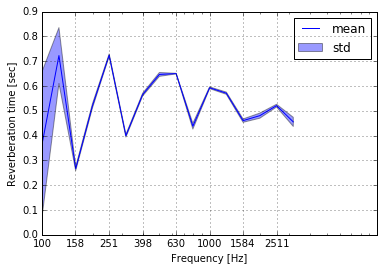

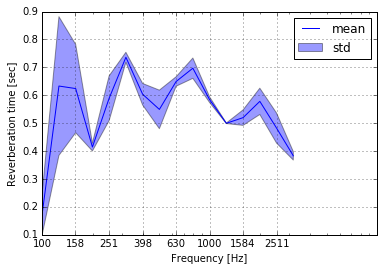

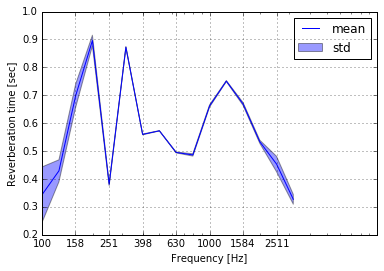

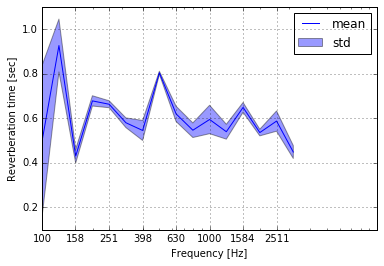

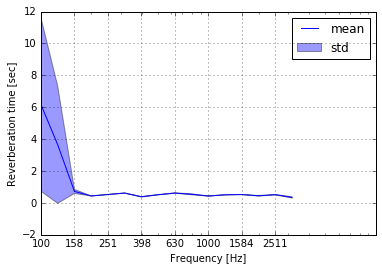

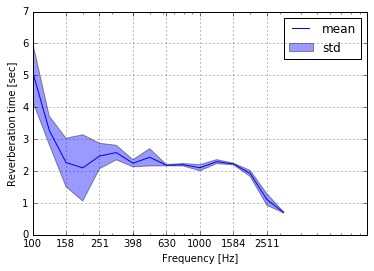

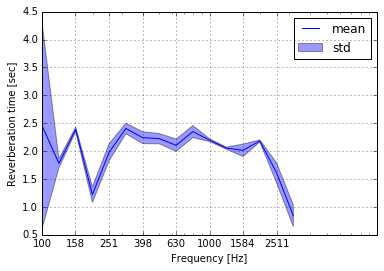

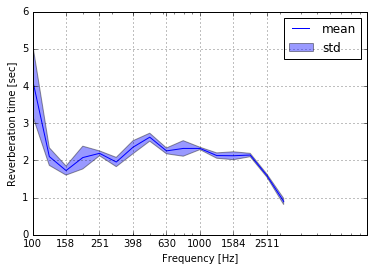

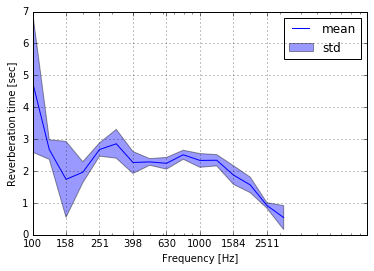

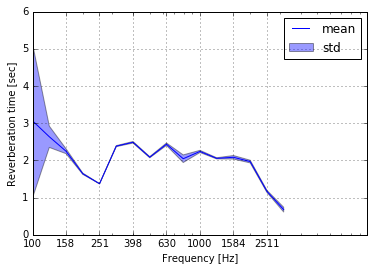

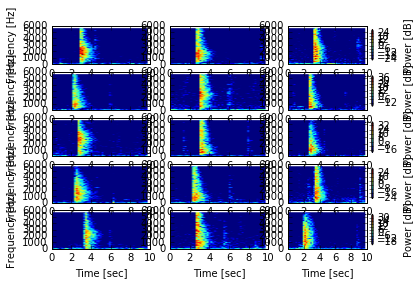

In [31]:
rt60_test('../../data/RT-Test/training-room/')
rt60_test('../../data/RT-Test/stair-case/')
plot_spectrogram('../../data/RT-Test/stair-case/')

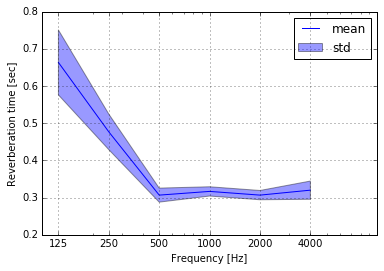

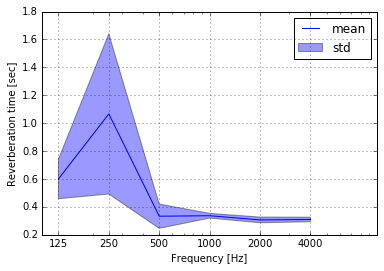

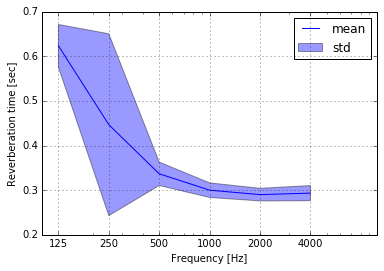

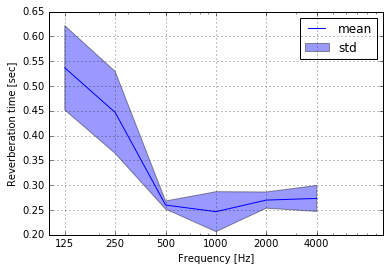

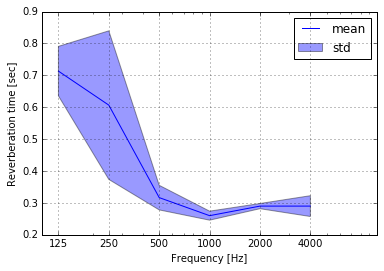

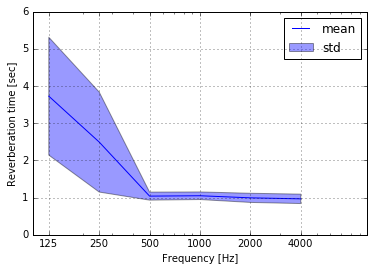

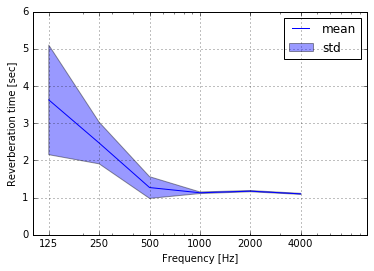

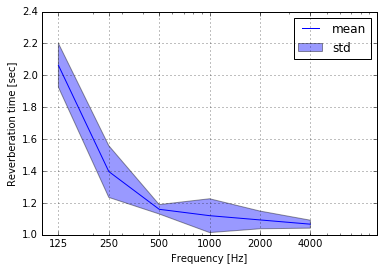

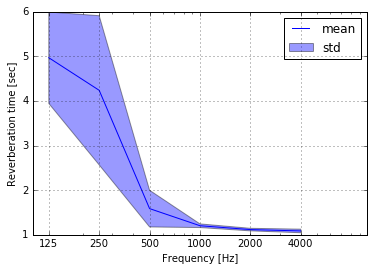

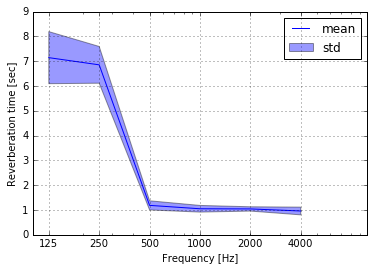

In [55]:
# Octave bands
octave_bands = np.array([125, 250, 500, 1000, 2000, 4000])
y_label = 'Reverberation time [sec]'


# Training room
pos1 = np.array([[0.73, 0.52, 0.28, 0.30, 0.32, 0.32],
                 [0.72, 0.50, 0.32, 0.32, 0.31, 0.35],
                 [0.54, 0.41, 0.32, 0.33, 0.29, 0.29]])

pos2 = np.array([[0.79, 0.86, 0.31, 0.36, 0.31, 0.31],
                 [0.56, 0.49, 0.24, 0.32, 0.28, 0.29],
                 [0.45, 1.85, 0.45, 0.33, 0.33, 0.33]])

pos3 = np.array([[0.69, 0.26, 0.36, 0.32, 0.27, 0.27],
                 [0.60, 0.35, 0.30, 0.28, 0.30, 0.30],
                 [0.58, 0.73, 0.35, 0.30, 0.30, 0.31]])

pos4 = np.array([[0.57, 0.50, 0.26, 0.27, 0.27, 0.31],
                 [0.62, 0.51, 0.25, 0.19, 0.29, 0.25],
                 [0.42, 0.33, 0.27, 0.28, 0.25, 0.26]])

pos5 = np.array([[0.71, 0.93, 0.28, 0.25, 0.28, 0.29],
                 [0.62, 0.39, 0.37, 0.28, 0.30, 0.33],
                 [0.81, 0.50, 0.30, 0.25, 0.29, 0.25]])

plot_app_data([pos1, pos2, pos3, pos4, pos5], octave_bands, y_label, ['pos1', 'pos2', 'pos3', 'pos4', 'pos5'])


# Stair case
pos1 = np.array([[5.91, 4.31, 1.09, 1.09, 1.07, 1.03],
                 [3.07, 2.07, 1.14, 1.15, 1.09, 1.08],
                 [2.20, 1.10, 0.89, 0.91, 0.82, 0.79]])

pos2 = np.array([[2.25, 3.02, 1.68, 1.15, 1.18, 1.09],
                 [2.96, 2.68, 1.11, 1.14, 1.19, 1.09],
                 [5.67, 1.70, 1.02, 1.10, 1.15, 1.12]])

pos3 = np.array([[2.14, 1.48, 1.17, 1.25, 1.17, 1.04],
                 [2.18, 1.54, 1.12, 0.99, 1.07, 1.10],
                 [1.87, 1.17, 1.19, 1.12, 1.04, 1.06]])

pos4 = np.array([[3.88, 2.47, 1.12, 1.15, 1.12, 1.11],
                 [4.68, 3.76, 2.12, 1.21, 1.15, 1.03],
                 [6.34, 6.48, 1.52, 1.25, 1.08, 1.12]])

pos5 = np.array([[8.61, 7.90, 1.21, 1.15, 1.06, 1.09],
                 [6.61, 6.28, 1.40, 1.14, 1.14, 1.05], 
                 [6.21, 6.38, 0.95, 0.86, 0.93, 0.74]])

plot_app_data([pos1, pos2, pos3, pos4, pos5], octave_bands, y_label, ['pos1', 'pos2', 'pos3', 'pos4', 'pos5'])

In [13]:
# Own implementation: Bluetoooth speaker, Pink Noise
spl_test('../../data/dataset/spl/bluetooth_speaker/PcbMic/pink_noise/')

In [29]:
# Octave bands
octave_bands = np.array([125, 250, 500, 1000, 2000, 4000])
y_label = ' Sound Pressure Level [dB]'


# SPL meter App : Bluetooth speaker, Pink Noise
pos1 = np.array([[36.0, 45.4, 48.1, 49.3, 45.2, 39.4],
                 [32.3, 43.9, 48.6, 49.7, 45.1, 39.5],
                 [37.9, 43.8, 49.6, 49.8, 45.5, 39.2]])

pos2 = np.array([[35.2, 47.2, 48.6, 50.8, 44.3, 39.7],
                 [33.3, 47.2, 47.7, 49.9, 44.2, 40.0],
                 [33.5, 47.3, 47.7, 49.3, 44.3, 39.6]])

pos3 = np.array([[34.6, 47.7, 50.1, 50.4, 46.2, 46.3],
                 [40.4, 49.0, 50.4, 50.7, 46.7, 44.4],
                 [38.3, 49.0, 49.6, 50.9, 46.4, 44.9]])

pos4 = np.array([[37.9, 44.4, 46.7, 47.4, 46.7, 39.7],
                 [41.1, 44.7, 46.2, 47.9, 46.9, 39.7],
                 [40.1, 43.2, 45.3, 50.0, 47.2, 40.6]])

pos5 = np.array([[36.6, 47.8, 48.3, 52.0, 48.5, 45.5],
                 [35.1, 47.8, 46.1, 51.8, 49.7, 46.3],
                 [36.7, 48.7, 48.0, 52.8, 48.9, 45.5]])

plot_app_data([pos1, pos2, pos3, pos4, pos5], octave_bands, y_label, ['pos1', 'pos2', 'pos3', 'pos4', 'pos5'])

# SPL meter App : Bluetooth speaker, White Noise
pos1 = np.array([[32.7, 44.0, 50.2, 54.6, 52.5, 46.7],
                 [31.7, 42.2, 48.9, 54.1, 51.2, 47.8],
                 [31.6, 43.7, 50.5, 54.3, 51.8, 46.5]])

pos2 = np.array([[28.1, 43.7, 49.2, 55.0, 50.5, 47.6],
                 [27.2, 45.3, 49.5, 53.3, 51.3, 48.6],
                 [28.8, 45.1, 49.2, 53.4, 51.6, 48.7]])

pos3 = np.array([[37.4, 46.3, 51.7, 54.7, 53.3, 53.5],
                 [35.8, 46.3, 51.8, 55.4, 53.4, 53.6],
                 [32.9, 47.0, 51.4, 55.0, 52.7, 53.7]])

pos4 = np.array([[33.8, 41.8, 47.1, 53.2, 53.3, 49.4],
                 [38.2, 42.8, 47.4, 52.1, 54.4, 49.7],
                 [37.9, 42.1, 46.4, 51.9, 53.6, 49.1]])

pos5 = np.array([[33.3, 46.0, 49.7, 56.2, 55.9, 54.8],
                 [32.9, 47.3, 48.0, 56.9, 55.7, 54.9],
                 [33.0, 45.4, 49.8, 54.9, 57.3, 55.1]])
plot_app_data([pos1, pos2, pos3, pos4, pos5], octave_bands, y_label, ['pos1', 'pos2', 'pos3', 'pos4', 'pos5'])

In [17]:
# Own implementation: Dodecahedron, Pink Noise
spl_test('../../data/dataset/spl/dodecahedron_speaker/')

In [28]:
# Octave bands
octave_bands = np.array([100, 125, 160, 200, 250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150])
y_label = ' Sound Pressure Level [dB]'

# Norsonic SPL meter: Dodecahedron, Pink noise
pos1 = np.array([94.8, 100.8, 106.4, 104.4, 104.7, 102.8, 100.3, 99.6, 98.2, 97.8, 95.2, 93.4, 94.5, 94.5, 93.5, 92.8])
pos2 = np.array([94.4, 100.6, 105.4, 103.5, 104.5, 102.6, 100.2, 99.2, 97.9, 97.7, 94.9, 93.3, 94.1, 94.4, 93.5, 92.7])
pos3 = np.array([94.0, 100.4, 105.7, 103.5, 104.4, 102.5, 99.8, 99.5, 97.9, 97.4, 95.0, 93.1, 94.3, 94.4, 93.7, 92.8])
pos4 = np.array([94.0, 100.7, 105.3, 103.3, 104.4, 102.4, 100.0, 99.4, 98.1, 97.4, 94.8, 93.0, 94.1, 94.6, 93.6, 92.8])
pos5 = np.array([94.7, 101.2, 105.4, 103.5, 104.6, 102.7, 99.8, 99.3, 98.0, 97.4, 94.7, 93.0, 94.3, 94.4, 93.6, 93.0])
p = np.vstack((pos1, pos2))
p = np.vstack((p, pos3))
p = np.vstack((p, pos4))
p = np.vstack((p, pos5))

plot_app_data([p], octave_bands, y_label, ['pos'], tick_scale=2)

In [35]:
################################################################################################
################################################################################################
################################################################################################
################################################################################################

In [49]:
# Own implementation: Furnished room, Reverberation time
rt60_test('../../data/dataset/rt60/furnished_room/')

In [60]:
# Octave bands
octave_bands = np.array([125, 250, 500, 1000, 2000, 4000])
y_label = 'Reverberation time [sec]'


# RT app: Furnished room, Reverberation time
pos1 = np.array([[0.73, 0.52, 0.28, 0.30, 0.32, 0.32],
                 [0.72, 0.50, 0.32, 0.32, 0.31, 0.35],
                 [0.54, 0.41, 0.32, 0.33, 0.29, 0.29]])

pos2 = np.array([[0.79, 0.86, 0.31, 0.36, 0.31, 0.31],
                 [0.56, 0.49, 0.24, 0.32, 0.28, 0.29],
                 [0.45, 1.85, 0.45, 0.33, 0.33, 0.33]])

pos3 = np.array([[0.69, 0.26, 0.36, 0.32, 0.27, 0.27],
                 [0.60, 0.35, 0.30, 0.28, 0.30, 0.30],
                 [0.58, 0.73, 0.35, 0.30, 0.30, 0.31]])

pos4 = np.array([[0.57, 0.50, 0.26, 0.27, 0.27, 0.31],
                 [0.62, 0.51, 0.25, 0.19, 0.29, 0.25],
                 [0.42, 0.33, 0.27, 0.28, 0.25, 0.26]])

pos5 = np.array([[0.71, 0.93, 0.28, 0.25, 0.28, 0.29],
                 [0.62, 0.39, 0.37, 0.28, 0.30, 0.33],
                 [0.81, 0.50, 0.30, 0.25, 0.29, 0.25]])

plot_app_data([pos1, pos2, pos3, pos4, pos5], octave_bands, y_label, ['pos1', 'pos2', 'pos3', 'pos4', 'pos5'])

In [61]:
# Own implementation: Staircase, Reverberation time
rt60_test('../../data/dataset/rt60/staircase/')

In [62]:
# Octave bands
octave_bands = np.array([125, 250, 500, 1000, 2000, 4000])
y_label = 'Reverberation time [sec]'

# RT app: Staircase, Reverberation time
pos1 = np.array([[5.91, 4.31, 1.09, 1.09, 1.07, 1.03],
                 [3.07, 2.07, 1.14, 1.15, 1.09, 1.08],
                 [2.20, 1.10, 0.89, 0.91, 0.82, 0.79]])

pos2 = np.array([[2.25, 3.02, 1.68, 1.15, 1.18, 1.09],
                 [2.96, 2.68, 1.11, 1.14, 1.19, 1.09],
                 [5.67, 1.70, 1.02, 1.10, 1.15, 1.12]])

pos3 = np.array([[2.14, 1.48, 1.17, 1.25, 1.17, 1.04],
                 [2.18, 1.54, 1.12, 0.99, 1.07, 1.10],
                 [1.87, 1.17, 1.19, 1.12, 1.04, 1.06]])

pos4 = np.array([[3.88, 2.47, 1.12, 1.15, 1.12, 1.11],
                 [4.68, 3.76, 2.12, 1.21, 1.15, 1.03],
                 [6.34, 6.48, 1.52, 1.25, 1.08, 1.12]])

pos5 = np.array([[8.61, 7.90, 1.21, 1.15, 1.06, 1.09],
                 [6.61, 6.28, 1.40, 1.14, 1.14, 1.05], 
                 [6.21, 6.38, 0.95, 0.86, 0.93, 0.74]])

plot_app_data([pos1, pos2, pos3, pos4, pos5], octave_bands, y_label, ['pos1', 'pos2', 'pos3', 'pos4', 'pos5'])

In [63]:
# Own implementation: Reverberation chamber, Reverberation time
rt60_test('../../data/dataset/rt60/reverberation_chamber/')

In [38]:
# Octave bands
octave_bands = np.array([100, 125, 160, 200, 250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150])
y_label = 'Reverberation time [sec]'

# Norsornic software: Reverberation chamber, Reverberation time
pos1 = np.array([7.65, 6.48, 6.20, 7.64, 6.58, 6.15, 5.93, 6.37, 6.17, 6.23, 5.82, 5.46, 5.45, 5.01, 4.40, 3.68])
pos2 = np.array([8.87, 5.79, 6.76, 7.21, 6.32, 6.33, 6.11, 6.35, 6.07, 5.84, 5.79, 5.55, 5.37, 5.09, 4.49, 3.65])
pos3 = np.array([14.09, 7.28, 6.27, 7.30, 6.44, 5.97, 6.62, 5.71, 6.05, 5.99, 5.56, 5.65, 5.31, 4.95, 4.48, 3.76])
pos4 = np.array([14.32, 6.50, 6.85, 7.82, 6.47, 5.28, 5.88, 5.51, 6.15, 5.67, 5.60, 5.56, 5.21, 4.96, 4.29, 3.61])
pos5 = np.array([13.47, 6.33, 6.34, 8.13, 7.27, 6.13, 5.66, 5.95, 5.82, 6.02, 5.50, 5.41, 5.48, 5.03, 4.49, 3.67])

p = np.vstack((pos1, pos2))
p = np.vstack((p, pos3))
p = np.vstack((p, pos4))
p = np.vstack((p, pos5)) # To Build spatial average
plot_app_data([p], octave_bands, y_label, ['pos'], tick_scale=2)

In [14]:
################################################################################################
################################################################################################
################################################################################################
################################################################################################
def verify_regulation(descriptor_list, file_name):
    octave_bands = building_acoustics_measurement.octave_bands
    ticks = np.asarray(octave_bands, dtype=np.int)[::1]
    descriptor_array = np.asarray(descriptor_list)

    descriptor_mean, l_bound, u_bound = get_mean_db(descriptor_array)
    l_bound = np.clip(l_bound, a_min=0.0, a_max=l_bound.max())
    
    single_number, ref_curve = building_acoustics_measurement.compute_single_number(descriptor_mean)

    plot_data([descriptor_mean, ref_curve[-1]], x_data=octave_bands, y_label='Sound Reduction Index [dB]',
              x_label='Frequency [Hz]', scale='log', fill_plot=True, fills=[l_bound, u_bound],
              file_name=file_name, args=ticks, multi_plot=True, legend=['R`', 'Ref. Curve'])

    return single_number

In [15]:
# Defect diagnosis :  Without lamp
octave_bands = np.array([100, 125, 160, 200, 250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150])
V = 52.1
S = 0.16

# source
tx_pos_1 = np.array([95.7, 103.2, 103.8, 104.8, 102.6, 101.3, 98.6, 98.6, 97.2, 96.4, 94.3, 93.0, 94.8, 94.9, 93.2, 91.4])
tx_pos_2 = np.array([90.9, 103.6, 102.0, 103.2, 97.4, 98.9, 98.5, 96.9, 96.5, 95.3, 93.0, 92.5, 94.5, 94.8, 94.0, 91.4])
tx_pos_3 = np.array([95.9, 105.7, 104.3, 104.9, 100.2, 99.7, 98.4, 96.8, 96.3, 94.4, 93.5, 92.5, 94.8, 94.4, 94.0, 92.6])
tx_pos_4 = np.array([91.7, 97.5, 102.8, 102.5, 101.4, 98.7, 98.4, 98.9, 95.8, 94.7, 94.3, 92.9, 94.7, 95.1, 92.9, 93.0])
tx_pos_5 = np.array([92.7, 99.8, 106.8, 103.1, 103.0, 101.7, 97.0, 97.2, 97.1, 95.5, 94.4, 92.1, 95.5, 95.3, 93.9, 92.5])

# receiver
rx_pos_1 = np.array([41.6, 48.6, 52.4, 47.7, 42.7, 40.1, 39.7, 35.4, 40.3, 31.1, 26.0, 25.3, 19.9, 25.1, 27.3, 27.7])
rx_pos_2 = np.array([42.8, 53.4, 53.2, 47.9, 44.0, 38.6, 37.4, 34.9, 38.9, 29.9, 24.9, 24.6, 19.9, 25.0, 27.9, 27.5])
rx_pos_3 = np.array([43.6, 55.4, 55.2, 48.8, 43.4, 39.1, 39.0, 35.2, 39.3, 32.5, 25.9, 25.6, 21.4, 25.8, 28.4, 28.6])
rx_pos_4 = np.array([43.2, 52.4, 51.4, 45.9, 44.3, 39.2, 39.6, 34.8, 39.9, 31.0, 25.1, 26.2, 19.9, 24.3, 26.7, 27.2])
rx_pos_5 = np.array([43.3, 53.7, 54.4, 47.7, 42.4, 39.5, 37.8, 33.7, 37.8, 29.8, 26.0, 25.1, 19.7, 24.9, 27.4, 27.3])

T = np.array([0.93, 1.12, 1.08, 1.03, 1.08, 1.09, 1.1, 1.13, 1.29, 1.27, 1.32, 1.3, 1.25, 1.25, 1.24, 1.17])

tx = [tx_pos_1, tx_pos_2, tx_pos_3, tx_pos_4, tx_pos_5]
rx = [rx_pos_1, rx_pos_2, rx_pos_3, rx_pos_4, rx_pos_5]
A = 0.16 * (V / T)

R_list = list()
for i in xrange(5):
    D = tx[i] - rx[i]
    R = D + 10 * np.log10(S/A)
    R_list.append(R)
    
verify_regulation(R_list, 'without_lamp')

48

In [30]:
# Defect diagnosis :  With lamp
V = 52.1
S = 0.16

# source
tx_pos_1 = np.array([96.4, 101.3, 105.4, 100.5, 105.1, 103.1, 99.2, 98.3, 96.5, 96.3, 94.4, 92.0, 94.7, 94.3, 93.6, 91.6])
tx_pos_2 = np.array([95.6, 101.1, 106.4, 98.6, 101.4, 101.5, 99.4, 97.2, 95.6, 95.7, 94.7, 93.4, 95.3, 94.6, 93.5, 91.6])
tx_pos_3 = np.array([99.3, 101.5, 109.6, 101.8, 101.2, 102.6, 99.6, 98.6, 97.2, 96.5, 93.3, 93.3, 94.2, 94.9, 93.1, 92.3])
tx_pos_4 = np.array([97.6, 98.0, 107.5, 100.6, 100.7, 99.9, 99.0, 96.9, 96.3, 95.3, 93.6, 92.8, 96.1, 95.0, 93.9, 92.3])
tx_pos_5 = np.array([97.8, 98.7, 104.8, 101.0, 100.2, 99.1, 98.0, 97.4, 94.7, 94.6, 92.9, 92.4, 95.3, 94.7, 93.4, 92.0])

# receiver
rx_pos_1 = np.array([48.2, 53.1, 52.4, 43.5, 41.1, 39.4, 37.4, 33.3, 29.7, 24.9, 25.1, 20.1, 17.7, 19.9, 18.4, 21.8])
rx_pos_2 = np.array([47.6, 51.3, 51.5, 46.4, 47.1, 38.7, 37.9, 32.1, 29.8, 24.9, 24.8, 19.8, 17.8, 18.4, 20.0, 20.6])
rx_pos_3 = np.array([45.3, 50.7, 53.6, 45.2, 41.4, 39.5, 37.5, 32.5, 28.8, 24.9, 25.7, 19.5, 17.8, 19.5, 19.5, 21.5])
rx_pos_4 = np.array([46.0, 51.5, 53.9, 45.6, 41.8, 40.1, 38.8, 32.2, 30.3, 25.9, 24.3, 20.0, 18.1, 18.8, 19.6, 21.3])
rx_pos_5 = np.array([46.1, 52.6, 55.3, 43.4, 39.2, 36.9, 39.2, 30.9, 29.7, 24.7, 24.3, 20.0, 17.9, 18.7, 20.5, 20.8])

T = np.array([0.93, 1.12, 1.08, 1.03, 1.08, 1.09, 1.1, 1.13, 1.29, 1.27, 1.32, 1.3, 1.25, 1.25, 1.24, 1.17])

tx = [tx_pos_1, tx_pos_2, tx_pos_3, tx_pos_4, tx_pos_5]
rx = [rx_pos_1, rx_pos_2, rx_pos_3, rx_pos_4, rx_pos_5]
A = 0.16 * (V / T)

R_list = list()
for i in xrange(5):
    D = tx[i] - rx[i]
    R = D + 10 * np.log10(S/A)
    R_list.append(R)
    
verify_regulation(R_list, 'with_lamp')

52

In [31]:
# Defect diagnosis :  With concrete
V = 52.1
S = 0.16

# source
tx_pos_1 = np.array([98.2, 103.9, 102.7, 103.2, 99.9, 98.6, 97.0, 96.6, 94.6, 94.9, 94.6, 92.9, 94.5, 94.5, 93.4, 92.1])
tx_pos_2 = np.array([97.7, 104.2, 107.2, 104.2, 102.7, 102.9, 98.3, 99.0, 96.4, 96.5, 94.8, 93.2, 95.2, 94.4, 94.0, 93.0])
tx_pos_3 = np.array([95.5, 102.0, 107.3, 103.4, 102.6, 103.1, 98.6, 98.3, 96.1, 97.0, 93.9, 93.3, 95.0, 94.7, 93.4, 91.7])
tx_pos_4 = np.array([96.5, 101.1, 105.4, 103.4, 102.2, 101.6, 99.0, 95.8, 95.2, 95.7, 93.0, 91.9, 94.8, 95.0, 93.9, 92.2])
tx_pos_5 = np.array([93.3, 100.6, 103.5, 103.4, 102.5, 99.1, 98.1, 98.0, 96.9, 95.9, 93.6, 92.1, 95.0, 95.3, 93.9, 92.7])


# receiver
rx_pos_1 = np.array([42.5, 46.6, 51.7, 47.2, 43.6, 37.5, 36.5, 32.0, 29.8, 25.2, 25.4, 17.6, 15.8, 14.7, 14.0, 12.3])
rx_pos_2 = np.array([42.1, 51.1, 52.4, 48.2, 43.8, 38.3, 38.0, 31.5, 29.5, 25.1, 26.5, 18.9, 15.9, 14.8, 14.0, 12.0])
rx_pos_3 = np.array([41.7, 54.3, 53.6, 47.1, 44.3, 38.2, 37.3, 32.7, 28.9, 26.0, 24.3, 17.4, 16.4, 14.8, 14.1, 12.2])
rx_pos_4 = np.array([43.5, 55.6, 55.0, 47.1, 42.5, 39.9, 37.8, 32.1, 28.2, 26.2, 25.8, 18.1, 15.4, 15.0, 15.0, 12.0])
rx_pos_5 = np.array([42.9, 49.7, 49.8, 47.6, 43.1, 38.8, 37.1, 31.8, 28.5, 26.1, 24.6, 17.8, 15.6, 14.0, 14.6, 12.5])

T = np.array([0.93, 1.12, 1.08, 1.03, 1.08, 1.09, 1.1, 1.13, 1.29, 1.27, 1.32, 1.3, 1.25, 1.25, 1.24, 1.17])

tx = [tx_pos_1, tx_pos_2, tx_pos_3, tx_pos_4, tx_pos_5]
rx = [rx_pos_1, rx_pos_2, rx_pos_3, rx_pos_4, rx_pos_5]
A = 0.16 * (V / T)

R_list = list()
for i in xrange(5):
    D = tx[i] - rx[i]
    R = D + 10 * np.log10(S/A)
    R_list.append(R)
    
verify_regulation(R_list, 'with_concrete')

52

In [10]:
spl_test('../../data/dataset/spl/dodecahedron_speaker/')
pos_5 = np.array([94.7, 101.2, 105.4, 103.5, 104.6, 102.7, 99.8, 99.3, 98.0, 97.4, 94.7, 93.0, 94.3, 94.4, 93.6, 93.0])

plt.figure()
plt.plot(pos_5)
plt.grid()

plt.show()

In [9]:
pos1 = np.array([7.65, 6.48, 6.20, 7.64, 6.58, 6.15, 5.93, 6.37, 6.17, 6.23, 5.82, 5.46, 5.45, 5.01, 4.40, 3.68])
pos2 = np.array([8.87, 5.79, 6.76, 7.21, 6.32, 6.33, 6.11, 6.35, 6.07, 5.84, 5.79, 5.55, 5.37, 5.09, 4.49, 3.65])
pos3 = np.array([14.09, 7.28, 6.27, 7.30, 6.44, 5.97, 6.62, 5.71, 6.05, 5.99, 5.56, 5.65, 5.31, 4.95, 4.48, 3.76])
pos4 = np.array([14.32, 6.50, 6.85, 7.82, 6.47, 5.28, 5.88, 5.51, 6.15, 5.67, 5.60, 5.56, 5.21, 4.96, 4.29, 3.61])
pos5 = np.array([13.47, 6.33, 6.34, 8.13, 7.27, 6.13, 5.66, 5.95, 5.82, 6.02, 5.50, 5.41, 5.48, 5.03, 4.49, 3.67])

rt60_mean = np.array([11.372, 6.622, 6.485, 7.60, 6.678, 6.005, 5.985, 5.968, 6.047, 5.953, 5.632, 5.585, 5.348,
                      4.978, 4.417, 3.663])

'''plt.plot(pos_1)
plt.plot(pos_2)
plt.plot(pos_3)
plt.plot(pos_4)
plt.plot(pos_5)'''
plt.plot(rt60_mean)
plt.grid()

In [44]:
def test_yied(root_dir, args='source'):
    data_folders = get_immediate_subdirectories(root_dir)
    
    count = 0
    for data_foo in data_folders:
        sub_foos = get_immediate_subdirectories(root_dir + data_foo)
        
        for foo in sub_foos:
            if foo == args:
                files = os.listdir(root_dir + data_foo + '/' + foo)
                rt60_list = list()
                
                for f in files:
                    file_path = root_dir + data_foo + '/' + foo + '/' + f
                    
                    yield load_data(file_path)
data = test_yied('../../data/RT-Test/stair-case/')
c = 0
for d in data:
    c += 1
print c

15


-22.3988159012


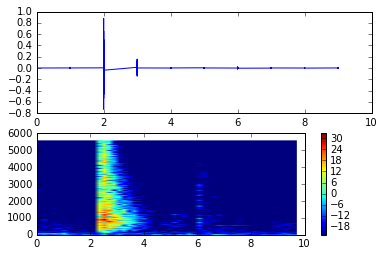

In [187]:
data = np.load('../../data/RT-Test/stair-case/2018-06-27-121930/background/5.npy')  # the signal
#data = abs(data / np.max(data))
NFFT = 1024 * 4       # the length of the windowing segments
Fs = 11025  # the sampling frequency
t = np.arange(data.size) / Fs


# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage
# instance

s = np.abs(np.fft.rfft(data))
vmin = 20 * np.log10(np.max(s)) - 60
#vmin = -30

print vmin

ax1 = plt.subplot(211)
plt.plot(t, data)
plt.subplot(212, sharex=ax1)
Pxx, freqs, bins, im = plt.specgram(data, NFFT=NFFT, Fs=Fs, noverlap=NFFT/2, mode='magnitude', vmin=vmin)
plt.colorbar(im)
plt.show()
